# Plotting ball on radar view

Warning : I am not a top python programmer so improvements are probably possible on the code bellow

The method relies mainly on ML and signal processing. This what I like to do : mixing Computer Vision with all kinds of different techniques trying to guess which one is interesting at different steps

## Ball detection and coordinate transformation

This can be done by assembling various components of the main programm
https://github.com/roboflow/sports/blob/main/examples/soccer/main.py

Then this script is just given for information

As one of the main problem is to detect when the ball is in the air, we need the whole time history of detections. This is the reason why all detections are stored in an array

In [1]:
def run_ball_radar(source_video_path: str, device: str) -> np.ndarray:
    """
    Run ball detection on a video and locate it on radar view.
    If sevral detections in one frame, all are kepts

    Args:
        source_video_path (str): Path to the source video.
        device (str): Device to run the model on (e.g., 'cpu', 'cuda').

    Retruns:
        np.ndarray: each line (frame_index, x_coordiante, y_ coordinate)
    """
    ball_detection_model = YOLO(BALL_DETECTION_MODEL_PATH).to(device=device)
    pitch_detection_model = YOLO(PITCH_DETECTION_MODEL_PATH).to(device=device)
    frame_generator = sv.get_video_frames_generator(source_path=source_video_path)
    ball_tracker = BallTracker(buffer_size=20)
    ball_annotator = BallAnnotator(radius=6, buffer_size=10)

    def callback(image_slice: np.ndarray) -> sv.Detections:
        result = ball_detection_model(image_slice, imgsz=640, verbose=False)[0]
        return sv.Detections.from_ultralytics(result)

    slicer = sv.InferenceSlicer(
        callback=callback,
        overlap_filter_strategy=sv.OverlapFilter.NONE,
        slice_wh=(640, 640),
    )
    i_frame = 0
    t0 = time.time()
    ball_xy = []
    for frame in frame_generator:
        detections = slicer(frame).with_nms(threshold=0.1)
        detections = ball_tracker.update(detections)
        
        result = pitch_detection_model(frame, verbose=False)[0]
        keypoints = sv.KeyPoints.from_ultralytics(result)
        
        mask = (keypoints.xy[0][:, 0] > 1) & (keypoints.xy[0][:, 1] > 1)
        transformer = ViewTransformer(
            source=keypoints.xy[0][mask].astype(np.float32),
            target=np.array(CONFIG.vertices)[mask].astype(np.float32)
        )
        xy = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
        transformed_xy = transformer.transform_points(points=xy)
        
        frame_xy = np.vstack((np.repeat(i_frame,len(transformed_xy)) , transformed_xy.T)).T
        
        if len(ball_xy) > 0:
            ball_xy = np.vstack((ball_xy, frame_xy))
        else: ball_xy = frame_xy.copy()

        i_frame += 1
        
        if i_frame % 50 == 0: 
            print(i_frame, f"{time.time() - t0:.2f}")
        
    return ball_xy

NameError: name 'np' is not defined

## Post processing of ball trajectory

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.signal import find_peaks

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph, KDTree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RANSACRegressor

from scipy.linalg import expm
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [3]:
source_video_path = 'data/2e57b9_0.mp4'

ball_xy = np.load(source_video_path[:-4] + '_ball.npy')
ball_xy[:5]

array([[0.0000000e+00, 1.4858859e+03, 3.0527632e+03],
       [1.0000000e+00, 1.4867784e+03, 3.0535281e+03],
       [2.0000000e+00, 1.4742407e+03, 3.0858040e+03],
       [3.0000000e+00, 1.4631831e+03, 3.1161887e+03],
       [4.0000000e+00, 1.4362982e+03, 3.1695132e+03]], dtype=float32)

We now have an array where each line is a ball detection, first the index of the frame for this detection and x and y coordiantes

(-207.76468200683598, 10269.522555541993, -7729.348376464844, 97.5864135742188)

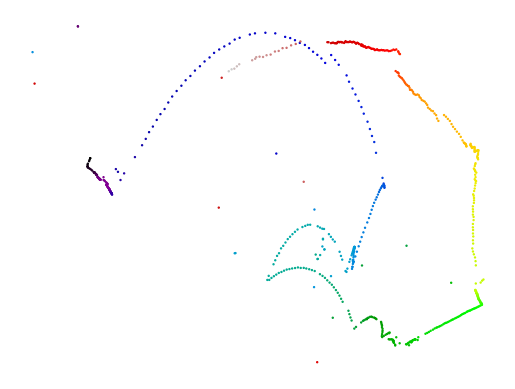

In [4]:
n_frame = ball_xy[:,0].max() + 1
plt.scatter (ball_xy[:,1], -ball_xy[:,2], c=ball_xy[:,0], 
                   norm = plt.Normalize(vmin=0, vmax=n_frame), cmap="nipy_spectral", s=0.5)
plt.axis('equal')
plt.axis('off')

Color changes according time.

To obtain a plat that has the same orientation as the radar view sign of y coordinate has to be changed

#### About the selection of the video

I took this video as ball is often in the air and a good test to solve this problem
It happens that we have some frame with no detection but no frame with several detection.

I believe desttroy information is never a good idea so I keep all detections even when they are several one in the same frame. In this case the detection that is clother to ball trajectory will be the better one. To make this selection I would recommand to build a graph and select the shortest path.

If you wish to see how tell me in which video this is needed ;)

## Detection of... false detections

False detections will be ouliers in the ball trajectory. As we can see, they appears as isolated points in the plot above.

This isolation in not only true in space (what we see on the plot), it is also true in time. Then to detect outliers we will keep frame indexes.

To detect points that are isolated we will use agglomerative clustering with 'single' leakage i.e. a cluster will be broken as soon as one detection is too far away.
An important point to use a clustering technique is choice of hyperparameter. And for that nothing is better tnat data themselves

In [5]:
fs = 25
Xraw = ball_xy.copy()

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(Xraw)
X[:,0] *= 2
tree = KDTree(X)
dist, ind = tree.query(X, k=max(fs//3, 10))
thresh = 2*np.quantile(dist[:,-1], 0.5)

First we normalize the data and then give more weight to the time dimension (intuition is that the ball can travel fast in space but not in time !)

And then determine what an abnormal distance can be using the data.

In [7]:
knn_graph = kneighbors_graph(X[:,0].reshape(-1,1), 5, include_self=False)
clustering = AgglomerativeClustering(n_clusters=None, linkage='single', 
                                     connectivity=knn_graph, distance_threshold=thresh)
clustering.fit(X)

AgglomerativeClustering(connectivity=<687x687 sparse matrix of type '<class 'numpy.float64'>'
	with 3435 stored elements in Compressed Sparse Row format>,
                        distance_threshold=0.15649464662108045,
                        linkage='single', n_clusters=None)

Then we underline a point should be considered in its neighbouring or local connectivity and apply the clustering 

In [8]:
labs, n_in_labs = np.unique(clustering.labels_, return_counts=True)
outs = np.array([])
for lab, n_in in zip(labs, n_in_labs):
    if n_in < 3:
        outs = np.append(outs, np.where(clustering.labels_== lab)[0])
outs = np.sort(outs).astype(np.int16)

"isolation" criteria is a cluster with two detections or less

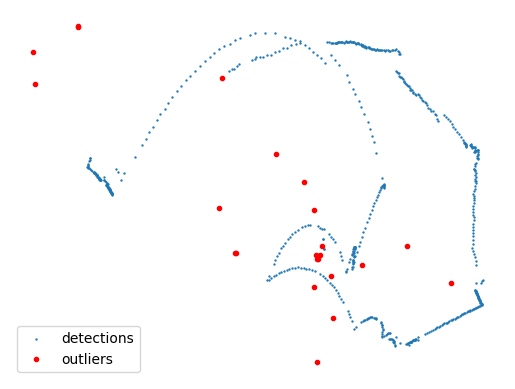

In [9]:
plt.scatter(ball_xy[:,1], -ball_xy[:,2], s=0.5)
plt.plot(ball_xy[outs,1], -ball_xy[outs,2],'r.')
plt.legend(['detections','outliers'])
plt.axis('equal')
plt.axis('off')
plt.show()

Not so bad !

If we consider the outlier in the vicinity of the end of the trajectory, it is a good example of a point that is not far in space but far in time.

Note : I also considered DBScan, Local Outlier Factor but results were not convincing

## Kalman smoothing

We can see in the last plot taht somme points seems to be out of the main trajectory and some erratic moves occur. In order too imrove that while keeping as mauch as physical meaning Kalman smoothing is a good tool.
To learn more about Kalman smoothin unsing filterpy I strongly recommand https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python it's realy fantastic.

Kalman smoothing uses the same basis as Kalman filtering and levrage the knowledge of "future" detections

To apply Kalman smoothing we need to have a detection at every time stamp.

Let's first delete the otliers and the interpolate missing values

In [10]:
ball_xy_val = np.delete(ball_xy, outs, axis=0)
f = interpolate.interp1d(ball_xy_val[:,0], ball_xy_val[:,1:], axis=0, fill_value='extrapolate')
frames = np.arange(ball_xy[-1,0]+1)
ball_int = f(frames)

Let's examine what we have so far

Text(0.5, 1.0, 'y')

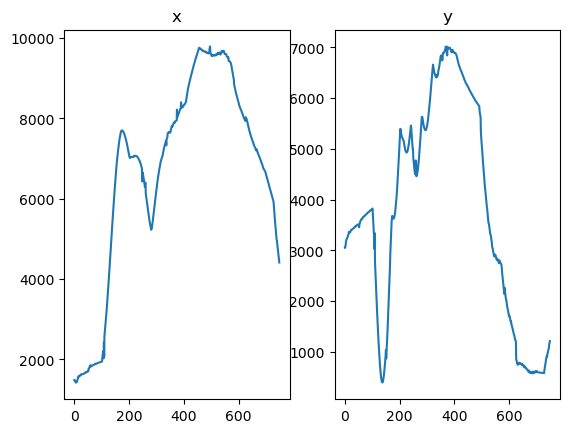

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(frames, ball_int[:,0])
ax1.set_title('x')
ax2.plot(frames, ball_int[:,1])
ax2.set_title('y')

We can see that depending on time, noise can show very different amplitudes and this is a limitation of Kalman smoothing as it optimizes a mean squared error. A way to get rid of big errors would be to apply an "aggressive" smoothing. But that would also lead to loss of meaningful signal especially when the ball changes direction suddenly like in the first half of this video. Let's try a way to arrange that.

To understand the meaning of different element in Kalman filter and how to tune parameters please refer to  https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

In [12]:
dim_x = 4
A = np.zeros((dim_x,dim_x))
for i in range(dim_x-1): A[i, i+1] = 1
dt = 1

f = KalmanFilter (dim_x=dim_x, dim_z=1)
f.F = expm(A * dt )

f.H = np.zeros((1,dim_x))
f.H[0,0] = 1
f.P *= 10. 
f.R = 100**2 

varQ = 10
f.Q = Q_discrete_white_noise(dim=dim_x, dt=dt, var=varQ**2)

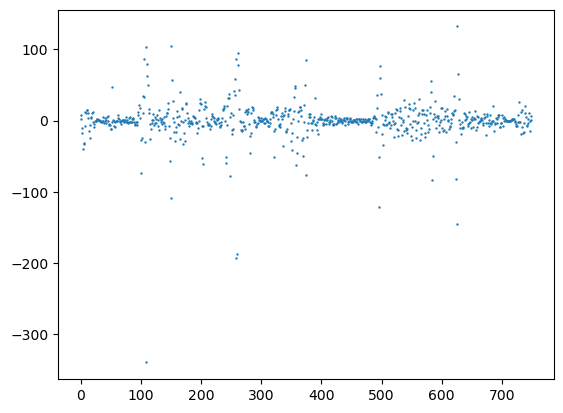

In [13]:
zs = ball_int[:,1].copy()

f.x = np.zeros((dim_x,1))
f.x[0,0] = zs[0]
mu, cov, _, _ = f.batch_filter(zs)
xs, Ps, Ks,_ = f.rts_smoother(mu, cov)

traj = xs.squeeze()[:,0]
deltas = traj - zs

plt.scatter(frames, deltas, s=0.5)

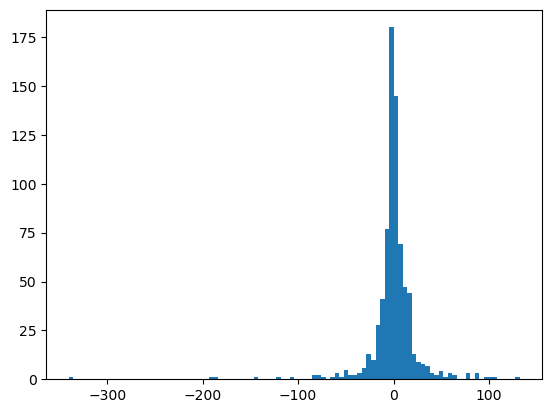

In [14]:
_ = plt.hist(deltas, bins=100)

These two plots show the same thing : distribution of error in "mainly" gaussian" and we have a few outliers.

There are some rigourous methods to tackle this problem but I suggest one which is easy to imlement : outliers are detected when a large error occurs and are replaced by the Kalman smoothing estimate.

Once again to define "big" error data statistics are used.

In [15]:
ball_int_save = ball_int.copy()
for i_loop in range(5):
    for i in range(2):
    
        zs = ball_int[:,i].copy()
        #f.x = np.array([[zs[0], 0, 0]]).T
        f.x = np.zeros((dim_x,1))
        f.x[0,0] = zs[0]
        mu, cov, _, _ = f.batch_filter(zs)
        xs, Ps, Ks,_ = f.rts_smoother(mu, cov)
        if i==0:
            traj = xs.squeeze()[:,0].copy()
            d_ball = xs.squeeze()[:,1].copy()
            d2_ball = xs.squeeze()[:,2].copy()
        else:
            traj = np.vstack((traj, xs.squeeze()[:,0])).T
            d_ball = np.vstack((d_ball, xs.squeeze()[:,1])).T
            d2_ball = np.vstack((d2_ball, xs.squeeze()[:,2])).T
            
    deltas = np.abs(traj - ball_int)
    thresholds = 5 * np.median(deltas,axis=0)
    print(thresholds)
    for i in range(2):
        ball_int[:,i] = np.where(deltas[:,i] < thresholds[i], ball_int[:,i], traj[:,i])

[20.0102473  29.81891568]
[16.37388877 25.37679908]
[15.97592599 24.29219762]
[15.86781636 23.99508458]
[15.75506673 23.66873935]


We can see that after the third iteration valeus of threshlod do not vary anymore. That could be a better termination criteria.

Let's plot the error

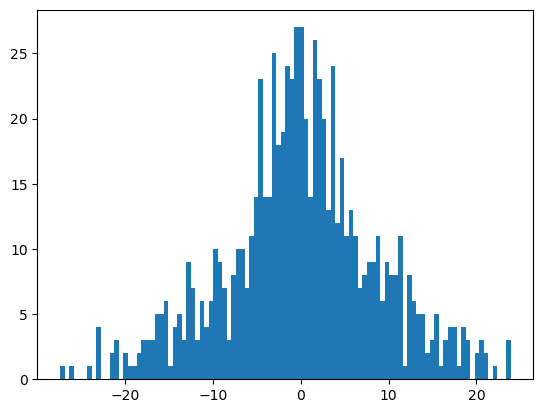

In [16]:
_ = plt.hist(traj[:,1] - zs, bins=100)

Ok, that is not a pure gaussian but not uggly and outliers are not here any more

And on the top of that for free we have an estimate of first and second derivatives

Let's have a look at our ball trajectory

(1012.7509613984148,
 10171.221318917207,
 -7322.791885084262,
 -65.50570533424161)

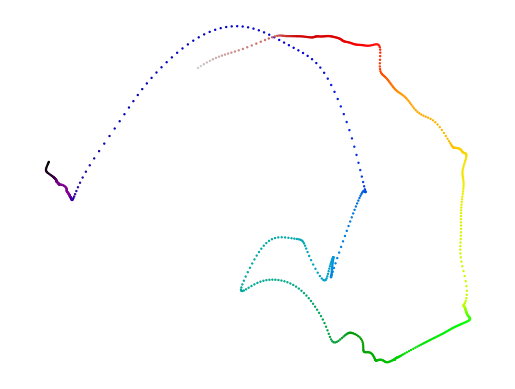

In [17]:
plt.scatter (traj[:,0], -traj[:,1], c=frames, 
                   norm = plt.Normalize(vmin=0, vmax=n_frame), cmap="nipy_spectral", s=0.5)
plt.axis('equal')
plt.axis('off')

## Detection of linear segment

When the ball is moving on the ground it's movment is rectilinear and uniform. Then portions of the trajectory should be linear.
To detect them I tried sevral tricks including Hough transform but it seems that RANSAC works best

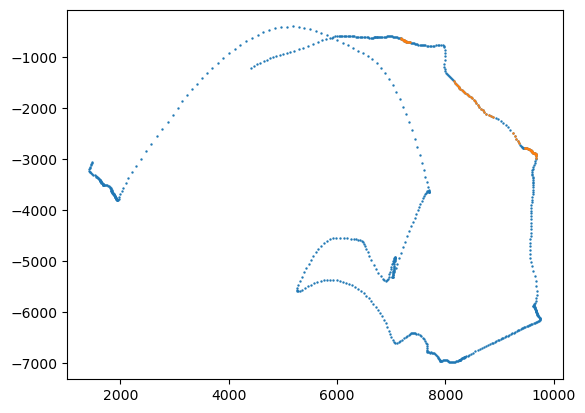

In [18]:
reg = RANSACRegressor(random_state=1, residual_threshold = 50)
reg.fit(traj[500:,1].reshape(-1,1), traj[500:,0])

plt.scatter(traj[:,0], -traj[:,1],s=0.5)
plt.scatter(traj[500:,0][reg.inlier_mask_], -traj[500:,1][reg.inlier_mask_], s=0.5)

This exemple (excluding the 500 first frames) is here to show that there is a risk the linear segment includes detections that come too soon or too late.

To avoid this situation we eliminate the part of the segment that is isolated. To do that we again use Agglomerative clustering

In addition to that it seems RANSAC is not so efficient when the slope is too big so we fit a regressor with both axes as reference. And once points have been attached to a linear segment they are deleted. Wrapping all that together gives

In [19]:
all_ins=[]

traj_reg = traj.copy()
reg_frames = frames.copy()
ins = []
long_seg = True
i = 0
while long_seg:

    reg1 = RANSACRegressor(random_state=i, residual_threshold = 50 )
    reg1.fit(traj_reg[:,0].reshape(-1,1), traj_reg[:,1])
    frames_in_reg_1 = reg_frames[reg1.inlier_mask_]

    clustering1 = AgglomerativeClustering(n_clusters=None, linkage='single', 
                                         distance_threshold=15)
    clustering1.fit(frames_in_reg_1.reshape(-1,1))
    labs1, n_in_labs1 = np.unique(clustering1.labels_, return_counts=True)
    
    reg2 = RANSACRegressor(random_state=i, residual_threshold = 50 )
    reg2.fit(traj_reg[:,1].reshape(-1,1), traj_reg[:,0])
    frames_in_reg_2 = reg_frames[reg2.inlier_mask_]

    clustering2 = AgglomerativeClustering(n_clusters=None, linkage='single', 
                                         distance_threshold=15)
    clustering2.fit(frames_in_reg_2.reshape(-1,1))
    labs2, n_in_labs2 = np.unique(clustering2.labels_, return_counts=True)
    
    n_max = max(n_in_labs1.max(), n_in_labs2.max())
    long_seg = n_max > 25
    
    if long_seg:
        
        if n_in_labs1.max() > n_in_labs2.max():
            new_ins = frames_in_reg_1[clustering1.labels_== np.argmax(n_in_labs1)].astype(np.int16)
        else:
            new_ins = frames_in_reg_2[clustering2.labels_== np.argmax(n_in_labs2)].astype(np.int16)
    
        ins.append(new_ins)
        indexes = np.searchsorted(reg_frames, new_ins)
        reg_frames = np.delete(reg_frames, indexes)
        traj_reg = np.delete(traj_reg, indexes, axis=0)
        i += 1
    else:
        all_ins = np.hstack(ins)

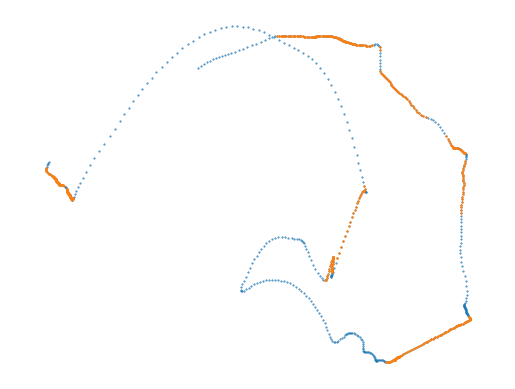

In [20]:
plt.scatter(traj[:,0], -traj[:,1], s=0.2)
plt.scatter(traj[all_ins,0], -traj[all_ins,1], s=0.5)
plt.axis('equal')
plt.axis('off')
plt.show()

On top of that we know that eack begining and ending of a linear segment is a vertice. So unless the ball experience a sudden change, the segment that joins verticies will also be included in the trajectory.

## Peaks of acceleration

So now we need to detect the points where ball rebunds on the ground (and keep the same direction) or a player (and direction changes).

When such rebunds occur, we have peaks in the acceleration of the ball. And remember, Kalman smoothing gave us an estimation of acceleration ! Calculation of curvature seems to be too noisy

In [21]:
acc = np.linalg.norm(d2_ball, axis=1)
peaks, properties = find_peaks(acc, distance= int(0.8*fs), prominence=10)

The peaks are interesting when the ball is in the air, that will last for a while. This is the reason we eliminate peaks that too clothe from each other or from a linear segment.

In [23]:
debs = np.sort(np.array([seg[0] for seg in ins]))
ends = np.sort(np.array([seg[-1] for seg in ins]))

peaks_in = []
for end, deb in zip(ends[:-1], debs[1:]):
    in_between = np.logical_and(peaks >= end + 8, peaks <= deb - 8)
    peaks_in.append(peaks[in_between])
new_pts = np.hstack(peaks_in)

vertices = np.hstack((debs, ends, new_pts, [0, frames[-1]]))
vertices = np.sort(np.unique(vertices)).astype(np.int16)

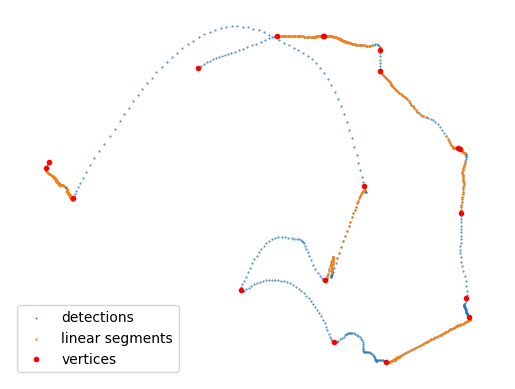

In [25]:
plt.scatter(traj[:,0], -traj[:,1], s=0.2)
plt.scatter(traj[all_ins,0], -traj[all_ins,1], s=0.5)
plt.plot(traj[vertices,0], -traj[vertices,1], 'r.')
plt.axis('equal')
plt.axis('off')
plt.legend(['detections','linear segments', 'vertices'])
plt.show()

## Final estimation of ball trajectory in radar view

Next we assume that when the ball rolls on ground and when it has a ballistic movement, the projection on the ground will be rectilinear with uniform speed.

We can see some imperfections :
- during the second linear segment there is a vertical control of the ball by one player which is not detected and this will lead to a false speed of the ball
- before third linear segment some rebunds are not detected and this will not cause error with the rectilinear assumption

In [27]:
f = interpolate.interp1d(vertices, traj[vertices], axis=0, fill_value='extrapolate')
ball_radar = f(frames)

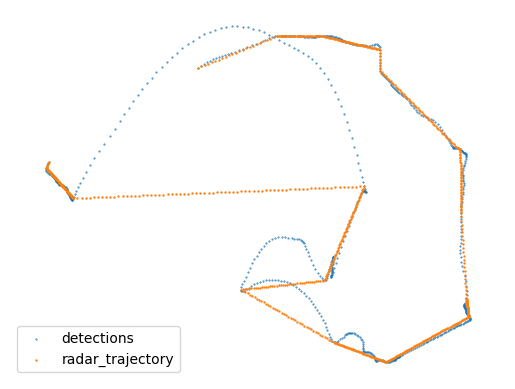

In [28]:
plt.scatter(traj[:,0], -traj[:,1], s=0.2)
plt.scatter(ball_radar[:,0], -ball_radar[:,1], s=0.5)
plt.axis('equal')
plt.axis('off')
plt.legend(['detections','radar_trajectory'])
plt.show()

Text(0.5, 1.0, 'y')

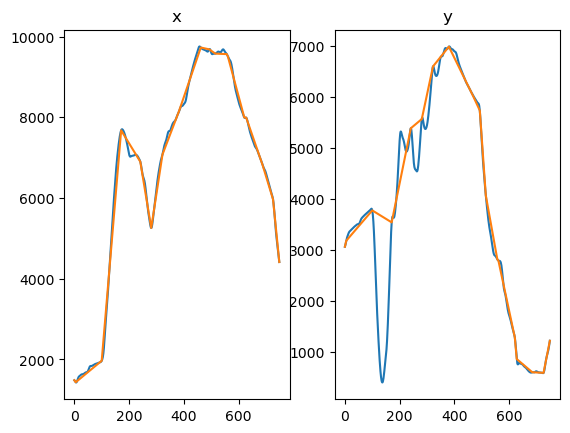

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(frames, traj[:,0])
ax1.plot(frames, ball_radar[:,0])
ax1.set_title('x')
ax2.plot(frames, traj[:,1])
ax2.plot(frames, ball_radar[:,1])
ax2.set_title('y')

In these plots, just after frame 200, we can see the error induce when missing the detection of the vertical control by one player

In [30]:
np.save(source_video_path[:-4] + '_ball_radar.npy', ball_radar)

The result has been included in a video available here https://drive.google.com/file/d/1FJvpVmD1kMLt1hgrkiUTy1bgqHvTp-e8/view?usp=sharing

I hope this will be useful for you.

I am a teacher at ENSTA Paris (Fance) and an independant consultant, if you have similar problems and think I can help : eric.fenaux@gmail.com